## Import All Required Libraries and Set Device

This cell imports all libraries needed for:
- File and directory operations (`os`, `zipfile`, `shutil`)
- Data processing and storage (`numpy`, `pandas`)
- Deep learning (PyTorch core, nn modules, optimizers, torchvision models and transforms)
- Data loading utilities (`Dataset`, `DataLoader`, `WeightedRandomSampler`)
- Image processing (`PIL`)
- MATLAB file loading (`scipy.io`)
- Data splitting and metrics (scikit-learn: `train_test_split`, `classification_report`, `confusion_matrix`, etc.)
- Plotting (`matplotlib`)
- Class weighting utilities (scikit-learn)
- Device selection: Automatically chooses GPU if available, otherwise falls back to CPU for computations.


In [ ]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Mount Google Drive, Extract Dataset, Convert Annotations, and Clean Data

This cell does the following:
- **Mounts Google Drive** to make files accessible in Colab.
- **Extracts the Stanford Cars dataset zip** file from your Google Drive into the working directory (only if not already extracted).
- **Loads the MATLAB annotation files** for the train and test sets and converts them to CSV files:
    - For the train set, saves both the image filenames and their corresponding class labels.
    - For the test set, saves just the image filenames.
- **Defines the root directories** for training and test images for later use.
- **Cleans the newly created CSV files** by removing any rows that reference image files which do not exist in the dataset folders, ensuring there are no missing images referenced in your splits.
- **Prints confirmation messages** when extraction and data cleaning are done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/stanford_cars.zip'
extract_dir = '/content/stanford_cars'
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
print("✅ Dataset extracted")

# Convert annotation files to CSV
train_annos = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_train_annos.mat")['annotations'][0]
train_rows = [[x[5][0], int(x[4][0]) - 1] for x in train_annos]
df_train = pd.DataFrame(train_rows, columns=["filename", "label"])
df_train.to_csv('/content/train_labels.csv', index=False)

test_annos = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_test_annos.mat")['annotations'][0]
test_rows = [[x[4][0]] for x in test_annos]
df_test = pd.DataFrame(test_rows, columns=["filename"])
df_test.to_csv('/content/test_labels.csv', index=False)

# Define root directories
train_root = f"{extract_dir}/cars_train/cars_train"
test_root = f"{extract_dir}/cars_test/cars_test"

# Remove any CSV rows for images that do not exist
df_train = df_train[df_train['filename'].apply(lambda f: os.path.exists(os.path.join(train_root, f)))]
df_train.to_csv('/content/train_labels.csv', index=False)
df_test = df_test[df_test['filename'].apply(lambda f: os.path.exists(os.path.join(test_root, f)))]
df_test.to_csv('/content/test_labels.csv', index=False)
print("✅ Cleaned dataset")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted


/tmp/ipython-input-2-509447208.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_rows = [[x[5][0], int(x[4][0]) - 1] for x in train_annos]


✅ Cleaned dataset


## Custom Dataset Class and Image Transformations

This cell does two things:

- **Defines the `StanfordCarsFromCSV` PyTorch Dataset class:**
    - Loads image file paths (and optionally labels) from a CSV file.
    - On each item access, loads the image from disk, applies any specified transformation, and returns either:
        - `(image_tensor, label)` for labeled data (training/validation), or
        - `(image_tensor, filename)` for unlabeled test data.

- **Sets up image transformations for training and validation/test:**
    - `train_transform`: Includes random resized cropping, horizontal flipping, rotation, color jitter, optional Gaussian blur, conversion to tensor, and normalization to ImageNet statistics. Used to augment and standardize training images.
    - `test_transform`: Only resizes, center-crops, converts to tensor, and normalizes images. Used for deterministic preprocessing in validation and testing.


In [ ]:
class StanfordCarsFromCSV(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, has_labels=True):
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.has_labels = has_labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.has_labels:
            return image, int(row['label'])
        return image, row['filename']

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


## Train/Validation Split, Dataset Instantiation, and DataLoader Setup

This cell performs several key dataset and loader preparation steps:

- **Splits the cleaned training data:**
    - Reads the full train labels CSV.
    - Splits into training and validation sets (10% validation), stratified by class to preserve class balance.
    - Saves new split CSVs for reproducibility.

- **Instantiates the custom PyTorch Dataset class** for each split:
    - `train_dataset` uses the training split and training transforms.
    - `val_dataset` uses the validation split and test transforms.
    - `test_dataset` uses the test set CSV and test transforms, with `has_labels=False`.

- **Handles class imbalance with weighted random sampling:**
    - Computes class weights for all training labels.
    - Builds a sample weight list for each example, then creates a `WeightedRandomSampler` for balanced batch sampling.

- **Creates DataLoaders for each dataset:**
    - Training uses the weighted sampler for balanced batches.
    - Validation and test use standard batching (no shuffle), for consistent evaluation.


In [ ]:
# Split into train and validation
df_all = pd.read_csv('/content/train_labels.csv')
df_train, df_val = train_test_split(df_all, test_size=0.1, stratify=df_all['label'], random_state=42)
df_train.to_csv('/content/train_split.csv', index=False)
df_val.to_csv('/content/val_split.csv', index=False)

train_dataset = StanfordCarsFromCSV(train_root, '/content/train_split.csv', train_transform)
val_dataset = StanfordCarsFromCSV(train_root, '/content/val_split.csv', test_transform)
test_dataset = StanfordCarsFromCSV(test_root, '/content/test_labels.csv', test_transform, has_labels=False)

# Weighted sampling for class balance
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## Model Definition, Parameter Freezing, Optimizer, Scheduler, and Loss Function

This cell sets up the model and optimization as follows:

- **Loads a pre-trained ResNet50 model** (with ImageNet weights).
- **Freezes all layers except:**
    - The third and fourth residual blocks (`layer3`, `layer4`)
    - The final fully connected layer (`fc`)
    Only these are set as trainable (fine-tuned).
- **Replaces the final classifier head** with a new sequential head:
    - Linear layer to 512 units
    - ReLU activation
    - Dropout (0.2) for regularization
    - Linear output layer to 196 classes (matching the number of car types)
- **Moves the model to the selected device** (GPU or CPU).
- **Sets up the Adam optimizer** with different learning rates for backbone layers and the classifier head.
- **Configures a learning rate scheduler** (`ReduceLROnPlateau`) to reduce LR when validation metric plateaus.
- **Sets the loss function** to cross-entropy with label smoothing for better calibration.


In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 196)
)
model = model.to(device)

optimizer = optim.Adam([
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3},
])
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


## Training and Validation Loop with Full Metrics Tracking, Early Stopping, and Model Checkpointing

This cell:

- **Imports additional metrics** from scikit-learn for use during validation (accuracy, precision, recall, F1, hamming loss, Cohen's kappa, Matthews correlation, Jaccard score).
- **Sets up training loop hyperparameters:** number of epochs, early stopping patience, and counters.
- **Initializes a metrics dictionary** to store all tracked statistics for each epoch, including losses, accuracies, multiple precision/recall/f1 variants, hamming, Cohen’s kappa, MCC, Jaccard, and top-3/top-5 accuracy.

**For each epoch:**
- **Training phase:**
    - Sets the model to train mode.
    - Loops through all training batches, moves data to device, computes predictions and loss, updates model, and accumulates loss and correct predictions for accuracy.
    - Appends average training loss and accuracy for the epoch to the metrics dictionary.
- **Validation phase:**
    - Sets the model to evaluation mode, disables gradients.
    - Loops through all validation batches, collects predictions, probabilities, losses, and true labels.
    - After all batches, calculates a wide range of metrics (precision/recall/F1—macro and weighted, top-3/top-5 accuracy, hamming loss, Cohen’s kappa, MCC, Jaccard).
    - Appends all validation metrics to the metrics dictionary.
- **Scheduler step:** Updates learning rate scheduler based on the validation macro F1 score.
- **Console logging:** Prints summary metrics (train/val accuracy, macro F1, top-3/top-5 accuracy) for the epoch.
- **Early stopping and checkpointing:** If current macro F1 is best so far, saves model and resets patience counter. Otherwise, increments counter and checks for early stopping. If patience is exceeded, training loop is broken.
- **Final model checkpoint:** After training, copies the best model checkpoint to Google Drive for safekeeping and prints confirmation.

**All tracking and saving operations are handled in this block for a streamlined experiment run.**


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, hamming_loss, cohen_kappa_score,
    matthews_corrcoef, jaccard_score
)
import torch.nn.functional as F

num_epochs = 25
patience, counter = 7, 0
best_val_f1 = 0

metrics_dict = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision_macro': [], 'val_precision_weighted': [],
    'val_recall_macro': [], 'val_recall_weighted': [],
    'val_f1_macro': [], 'val_f1_weighted': [],
    'val_hamming': [], 'val_cohen_kappa': [],
    'val_mcc': [], 'val_jaccard_macro': [],
    'val_top3': [], 'val_top5': [],
}

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total
    metrics_dict['train_loss'].append(train_loss)
    metrics_dict['train_acc'].append(train_acc)

    # --- VALIDATION ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_probs, val_preds, val_targets = [], [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            v_loss = criterion(outputs, labels)
            val_loss += v_loss.item() * imgs.size(0)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_probs.extend(probs.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_preds_np = np.array(val_preds)
    val_targets_np = np.array(val_targets)
    val_probs_np = np.array(val_probs)

    # Standard metrics
    val_precision_macro = precision_score(val_targets_np, val_preds_np, average='macro', zero_division=0)
    val_precision_weighted = precision_score(val_targets_np, val_preds_np, average='weighted', zero_division=0)
    val_recall_macro = recall_score(val_targets_np, val_preds_np, average='macro', zero_division=0)
    val_recall_weighted = recall_score(val_targets_np, val_preds_np, average='weighted', zero_division=0)
    val_f1_macro = f1_score(val_targets_np, val_preds_np, average='macro', zero_division=0)
    val_f1_weighted = f1_score(val_targets_np, val_preds_np, average='weighted', zero_division=0)
    # Top-k
    top3_acc = np.mean([
        label in np.argsort(prob)[-3:] for prob, label in zip(val_probs_np, val_targets_np)
    ])
    top5_acc = np.mean([
        label in np.argsort(prob)[-5:] for prob, label in zip(val_probs_np, val_targets_np)
    ])
    # Other metrics
    val_hamming = hamming_loss(val_targets_np, val_preds_np)
    val_cohen_kappa = cohen_kappa_score(val_targets_np, val_preds_np)
    val_mcc = matthews_corrcoef(val_targets_np, val_preds_np)
    val_jaccard_macro = jaccard_score(val_targets_np, val_preds_np, average='macro', zero_division=0)

    # Append all
    metrics_dict['val_loss'].append(val_loss)
    metrics_dict['val_acc'].append(val_acc)
    metrics_dict['val_precision_macro'].append(val_precision_macro)
    metrics_dict['val_precision_weighted'].append(val_precision_weighted)
    metrics_dict['val_recall_macro'].append(val_recall_macro)
    metrics_dict['val_recall_weighted'].append(val_recall_weighted)
    metrics_dict['val_f1_macro'].append(val_f1_macro)
    metrics_dict['val_f1_weighted'].append(val_f1_weighted)
    metrics_dict['val_hamming'].append(val_hamming)
    metrics_dict['val_cohen_kappa'].append(val_cohen_kappa)
    metrics_dict['val_mcc'].append(val_mcc)
    metrics_dict['val_jaccard_macro'].append(val_jaccard_macro)
    metrics_dict['val_top3'].append(top3_acc)
    metrics_dict['val_top5'].append(top5_acc)

    scheduler.step(val_f1_macro)

    print(f"Epoch {epoch+1:2d} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"F1(macro): {val_f1_macro:.4f} | Top3: {top3_acc:.3f} | Top5: {top5_acc:.3f}")

    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        torch.save(model.state_dict(), 'twin_car_best_model_v2.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

shutil.copy('twin_car_best_model_v2.pth', '/content/drive/MyDrive/twin_car_best_model_v2.pth')
print("✅ Best model saved")

Epoch  1 | Train Acc: 0.1188 | Val Acc: 0.2196 | F1(macro): 0.1721 | Top3: 0.449 | Top5: 0.548
Epoch  2 | Train Acc: 0.4486 | Val Acc: 0.4454 | F1(macro): 0.4174 | Top3: 0.659 | Top5: 0.752
Epoch  3 | Train Acc: 0.6607 | Val Acc: 0.5730 | F1(macro): 0.5461 | Top3: 0.779 | Top5: 0.844
Epoch  4 | Train Acc: 0.7764 | Val Acc: 0.6344 | F1(macro): 0.6185 | Top3: 0.831 | Top5: 0.875
Epoch  5 | Train Acc: 0.8480 | Val Acc: 0.6724 | F1(macro): 0.6573 | Top3: 0.856 | Top5: 0.908
Epoch  6 | Train Acc: 0.8921 | Val Acc: 0.6785 | F1(macro): 0.6662 | Top3: 0.865 | Top5: 0.907
Epoch  7 | Train Acc: 0.9172 | Val Acc: 0.7202 | F1(macro): 0.7059 | Top3: 0.870 | Top5: 0.915
Epoch  8 | Train Acc: 0.9404 | Val Acc: 0.6908 | F1(macro): 0.6732 | Top3: 0.881 | Top5: 0.921
Epoch  9 | Train Acc: 0.9517 | Val Acc: 0.7313 | F1(macro): 0.7167 | Top3: 0.892 | Top5: 0.934
Epoch 10 | Train Acc: 0.9608 | Val Acc: 0.7546 | F1(macro): 0.7444 | Top3: 0.898 | Top5: 0.935
Epoch 11 | Train Acc: 0.9655 | Val Acc: 0.7620 | F

In [ ]:
model.load_state_dict(torch.load('twin_car_best_model_v2.pth', map_location=device))
model.eval()
print("✅ Loaded best model weights.")

import scipy.io
meta = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_meta.mat")
class_names = [x[0] for x in meta['class_names'][0]]

✅ Loaded best model weights.


## Validation Set Inference, Classification Report Export, and Confusion Matrix Plot

This cell performs model evaluation and reporting in one go:

- **Loads class names** from the metadata file for use in reports and plots.
- **Runs inference on the entire validation set** with the trained model (in evaluation mode, no gradients), collecting all predicted and true labels.
- **Generates a detailed classification report** (precision, recall, F1, and support for each class, as well as averages) using scikit-learn, then saves it as a CSV file (`classification_report.csv`).
- **Computes and plots the confusion matrix** for the validation predictions, using true class names as axis labels, then saves the plot as `classification_matrix.png` and also displays it in the notebook.
- **Prints confirmation** when the classification report is saved.

This block allows you to analyze per-class and overall performance as well as visualize confusion between classes.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ classification_report.csv saved.


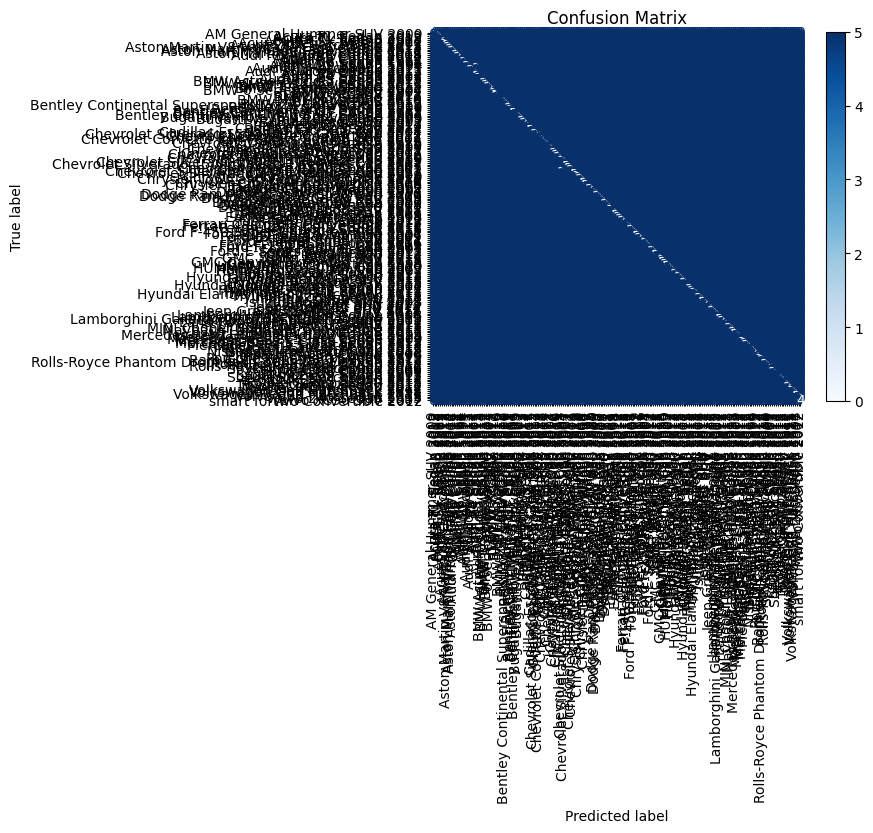

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import scipy.io

# Prepare class names
meta = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_meta.mat")
class_names = [x[0] for x in meta['class_names'][0]]

# Inference on validation set
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report to CSV
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
pd.DataFrame(report).transpose().to_csv('classification_report.csv')
print("✅ classification_report.csv saved.")

# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.savefig('classification_matrix.png', bbox_inches='tight')
plt.show()


## Test Set Inference and Export of Predicted Class Names

This cell performs the following:

- **Runs inference on the entire test set** (no labels), disabling gradients for speed.
    - For each batch, moves images to the correct device and predicts class indices.
    - Collects all predictions and corresponding filenames.
- **Converts class indices to human-readable class names** using the loaded class_names list.
- **Creates a DataFrame** pairing each test image filename with its predicted class name.
- **Exports the results to a CSV file** (`test_predictions_named.csv`), which is suitable for competition submission or analysis.
- **Prints a confirmation** when the CSV is saved.

All steps required for generating and saving model predictions on the test set are bundled here.


In [ ]:
preds, filenames = [], []
with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()
        preds.extend(pred)
        filenames.extend(names)

predicted_names = [class_names[i] for i in preds]
results_df = pd.DataFrame({'filename': filenames, 'class_name': predicted_names})
results_df.to_csv('test_predictions_named.csv', index=False)
print("✅ test_predictions_named.csv saved.")


✅ test_predictions_named.csv saved.


## Visualize Most Confused Class Pairs and Top-20 Class Accuracies

This cell creates two diagnostic visualizations from the validation confusion matrix:

- **Most Confused Classes:**
    - Copies the confusion matrix and zeros out the diagonal (correct predictions).
    - Identifies the 20 classes with the highest number of off-diagonal confusions.
    - Extracts the corresponding sub-matrix and class labels.
    - Plots a confusion matrix for these 20 most confused classes, saves it as `top20_confused.png`, and displays it in the notebook.

- **Top-20 Most Accurate Classes:**
    - Computes per-class accuracy by dividing correct predictions by total instances for each class.
    - Sorts all classes by accuracy and selects the top 20.
    - Plots a horizontal bar chart of these top-accuracy classes using Seaborn, saves the plot as `top20_accuracy.png`, and displays it.

These plots help you quickly spot which car classes are hardest for the model to distinguish and which are easiest.


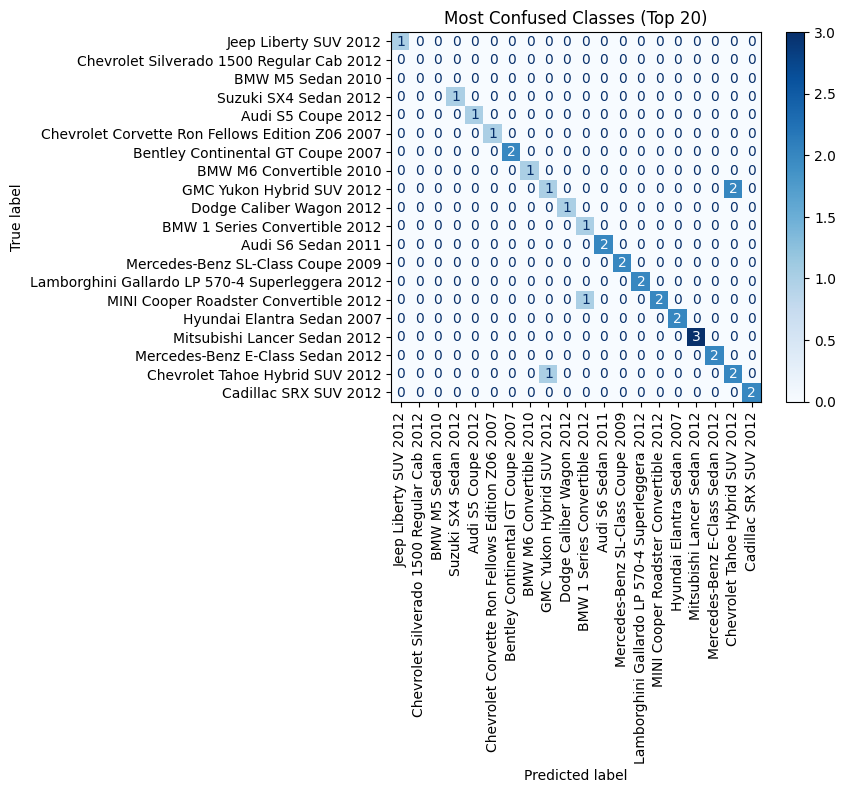

/tmp/ipython-input-11-3360419761.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_acc, x='accuracy', y='class', palette='Blues_d')


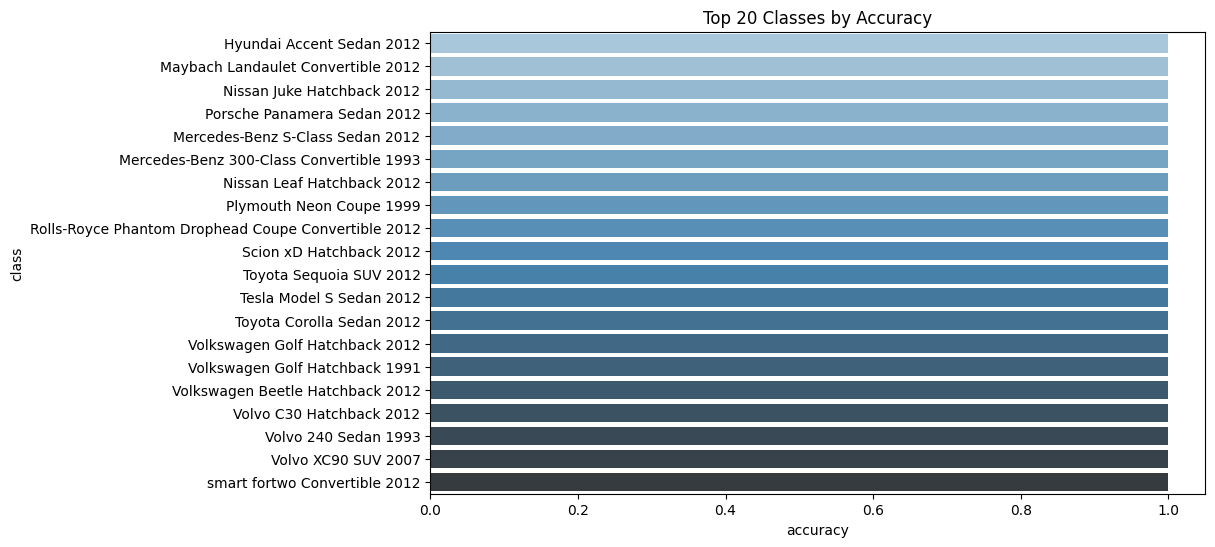

In [ ]:
import numpy as np
import seaborn as sns

# Most confused classes
off_diagonal = cm.copy()
np.fill_diagonal(off_diagonal, 0)
most_confused = np.argsort(off_diagonal.sum(axis=1))[::-1][:20]
cm_top = cm[np.ix_(most_confused, most_confused)]
labels_top = [class_names[i] for i in most_confused]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels_top)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title('Most Confused Classes (Top 20)')
plt.savefig("top20_confused.png", bbox_inches='tight')
plt.show()

# Top accuracy classes
acc_per_class = cm.diagonal() / cm.sum(axis=1)
df_acc = pd.DataFrame({'class': class_names, 'accuracy': acc_per_class})
top_acc = df_acc.sort_values('accuracy').tail(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top_acc, x='accuracy', y='class', palette='Blues_d')
plt.title('Top 20 Classes by Accuracy')
plt.savefig("top20_accuracy.png", bbox_inches='tight')
plt.show()


## Export Training Metrics to CSV and Plot All Major Training Curves

This cell processes and visualizes the tracked training/validation metrics:

- **Saves the full training/validation metrics dictionary** as a DataFrame (`metrics_df`) to a CSV file (`metrics_log.csv`), one row per epoch.
- **Plots and saves training/validation accuracy and macro F1 per epoch** in one figure (`metrics_curve.png`).
- **Plots and saves training/validation loss per epoch** in a separate figure (`train_val_loss_curves.png`).
- **Plots and saves validation precision and recall (macro and weighted)** in a figure (`val_precision_recall_curves.png`).
- **If available, plots and saves top-3 and top-5 validation accuracy curves** (`val_top3_top5_curves.png`).
- **Displays all plots in the notebook** and prints a final confirmation when all key metric plots have been saved.

This block provides a comprehensive view of your model's learning and generalization behavior throughout training.


✅ metrics_log.csv saved.


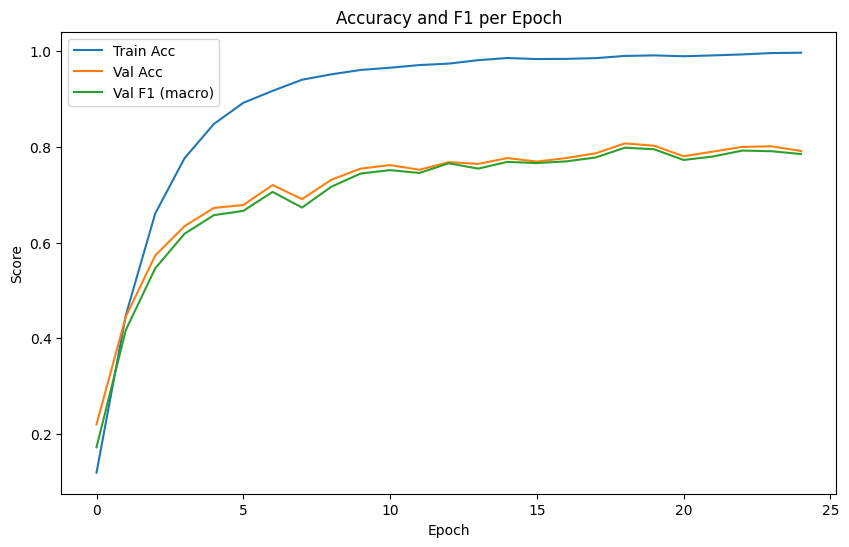

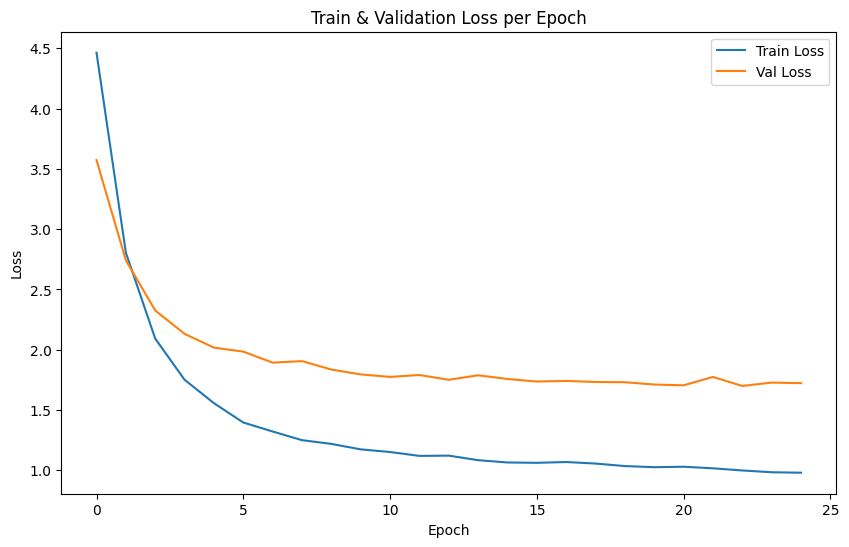

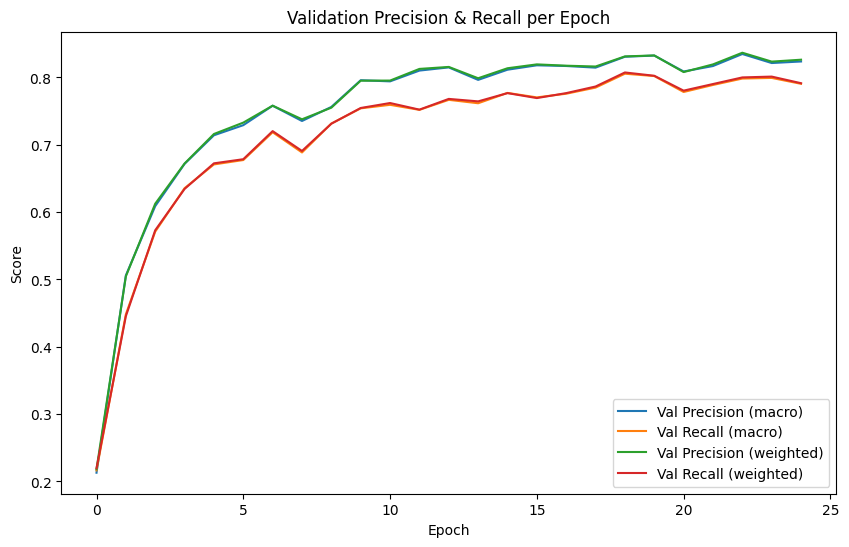

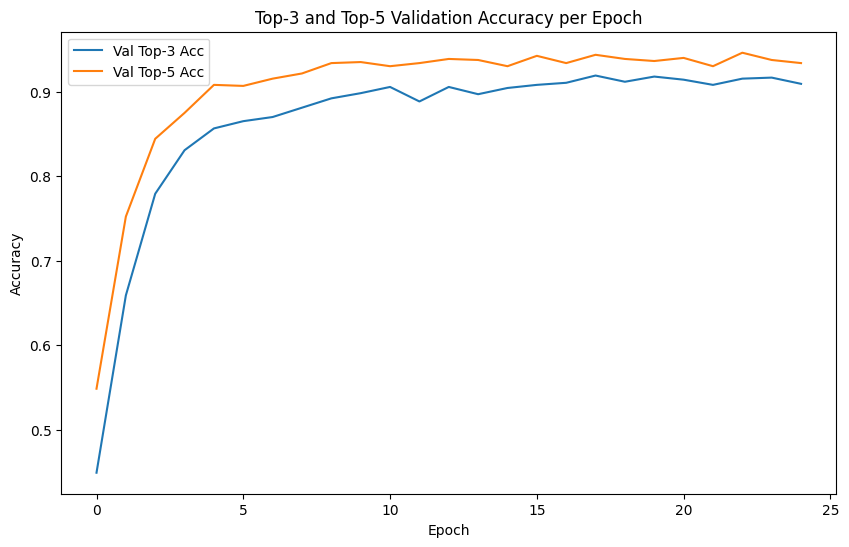

✅ All key metric plots saved!


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert metrics_dict to DataFrame and save as CSV
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('metrics_log.csv', index_label='epoch')
print("✅ metrics_log.csv saved.")

# 2. Plot Training & Validation Accuracy and Macro F1
plt.figure(figsize=(10,6))
plt.plot(metrics_df['train_acc'], label='Train Acc')
plt.plot(metrics_df['val_acc'], label='Val Acc')
plt.plot(metrics_df['val_f1_macro'], label='Val F1 (macro)')
plt.title('Accuracy and F1 per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.savefig('metrics_curve.png')
plt.show()

# 3. Plot Training & Validation Loss
plt.figure(figsize=(10,6))
plt.plot(metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['val_loss'], label='Val Loss')
plt.title('Train & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_val_loss_curves.png')
plt.show()

# 4. Plot Precision & Recall (Macro and Weighted)
plt.figure(figsize=(10,6))
plt.plot(metrics_df['val_precision_macro'], label='Val Precision (macro)')
plt.plot(metrics_df['val_recall_macro'], label='Val Recall (macro)')
plt.plot(metrics_df['val_precision_weighted'], label='Val Precision (weighted)')
plt.plot(metrics_df['val_recall_weighted'], label='Val Recall (weighted)')
plt.title('Validation Precision & Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.savefig('val_precision_recall_curves.png')
plt.show()

# 5. Plot Top-3 and Top-5 Validation Accuracy (if available)
if 'val_top3' in metrics_df.columns and 'val_top5' in metrics_df.columns:
    plt.figure(figsize=(10,6))
    plt.plot(metrics_df['val_top3'], label='Val Top-3 Acc')
    plt.plot(metrics_df['val_top5'], label='Val Top-5 Acc')
    plt.title('Top-3 and Top-5 Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('val_top3_top5_curves.png')
    plt.show()

print("✅ All key metric plots saved!")


## Test Set Inference and Save Predictions with Class Names

This cell:

- **Loads class names** from the metadata file (to ensure correct mapping from predicted indices to labels).
- **Runs inference on the entire test set** (in evaluation mode, no gradients), collecting predicted class indices and filenames for each test image.
- **Maps predicted class indices to their corresponding class names**.
- **Creates and saves a DataFrame** containing each test image filename and its predicted class name as a CSV file (`test_predictions_named.csv`).
- **Prints a confirmation** once the CSV is saved.

This cell repeats and ensures that test set predictions are correctly mapped and exported, which is critical for accurate submission or downstream analysis.


In [ ]:
import pandas as pd
import scipy.io

# Make sure you have the correct class names
meta = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_meta.mat")
class_names = [x[0] for x in meta['class_names'][0]]

preds, filenames = [], []
with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()
        preds.extend(pred)
        filenames.extend(names)

predicted_names = [class_names[i] for i in preds]
results_df = pd.DataFrame({'filename': filenames, 'class_name': predicted_names})
results_df.to_csv('test_predictions_named.csv', index=False)
print("✅ test_predictions_named.csv saved.")


✅ test_predictions_named.csv saved.


## Grad-CAM++ Visualization for Model Explainability

This cell enables visual model interpretability as follows:

- **Ensures the Grad-CAM package is installed** (using a pip command in Colab/Jupyter).
- **Imports all required Grad-CAM and utility modules**, as well as standard libraries for image processing and OS operations.
- **Creates an output directory (`gradcam_outputs`)** for saving Grad-CAM result images.
- **Configures the model and Grad-CAM++:**
    - Puts the model in evaluation mode on the appropriate device.
    - Selects the last block of `layer4` as the Grad-CAM target layer.
    - Initializes the GradCAMPlusPlus object with this configuration.
- **Iterates through the first 5 images of the test dataset:**
    - For each image, computes the model's predicted class index.
    - Computes the Grad-CAM++ heatmap for the predicted class.
    - De-normalizes the input image for proper display.
    - Overlays the Grad-CAM heatmap onto the original image.
    - Saves the resulting visualization to disk and displays it in the notebook.
    - Handles exceptions and prints errors if any image fails.

This provides qualitative insight into which regions of an input image most influenced the model's prediction, enhancing trust and interpretability.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.9 MB/s e

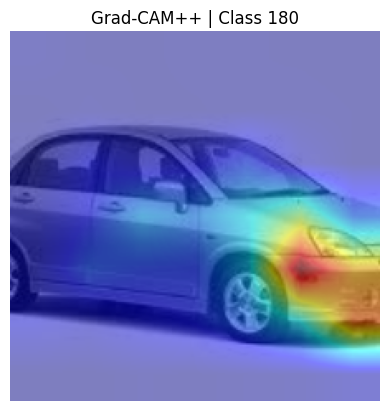

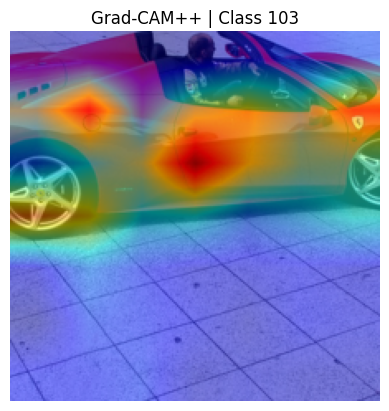

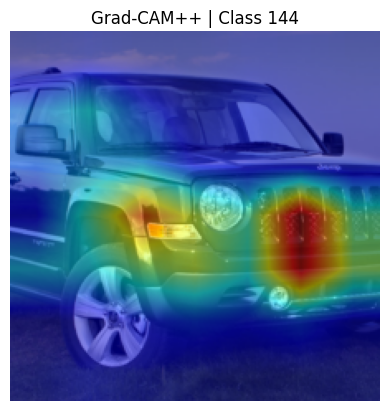

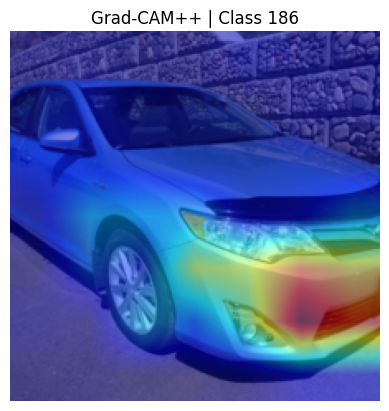

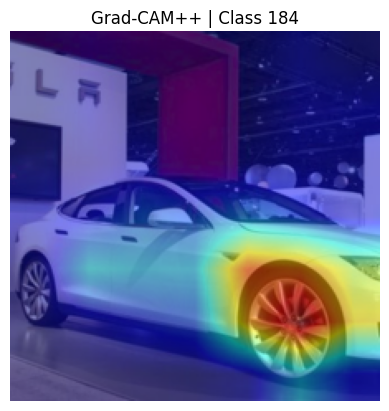

In [ ]:
# Make sure Grad-CAM is installed:
!pip install -U grad-cam

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import numpy as np
import os

os.makedirs('gradcam_outputs', exist_ok=True)
model.eval().to(device)
target_layer = model.layer4[-1]
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

for i in range(5):  # Visualize first 5 test images (or val_dataset[i] if you want)
    try:
        image_tensor = test_dataset[i][0]
        input_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        pred_idx = outputs.argmax().item()
        targets = [ClassifierOutputTarget(pred_idx)]
        cam_input = input_tensor.requires_grad_()
        grayscale_cam = cam(input_tensor=cam_input, targets=targets)
        if grayscale_cam is None or grayscale_cam[0] is None:
            continue
        grayscale_cam = grayscale_cam[0]
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)
        vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        filename = f"gradcam_outputs/campp_{i:02d}_class_{pred_idx}.png"
        Image.fromarray(vis).save(filename)
        plt.imshow(vis)
        plt.title(f"Grad-CAM++ | Class {pred_idx}")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"❌ Failed on image {i}: {e}")


In [ ]:
from sklearn.metrics import classification_report

# You already have class_names from before
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
pd.DataFrame(report).transpose().to_csv('classification_report.csv')
print("✅ classification_report.csv saved.")


✅ classification_report.csv saved.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gradio Web Interface for Interactive Inference and Grad-CAM Explainability

This cell creates a user-friendly demo for model prediction and visual explanation:

- **Defines the `predict_and_explain` function:**
    - Accepts a user-uploaded image, resizes and preprocesses it for the model.
    - Runs the model to get the predicted class.
    - Computes a Grad-CAM++ heatmap for the predicted class.
    - Overlays the Grad-CAM heatmap on the original image.
    - Returns both the visualization and a text prediction (class name and ID).

- **Configures a Gradio Interface:**
    - Users can upload a car image via a drag-and-drop widget.
    - The interface displays both the Grad-CAM++ visualization and the predicted class.
    - Includes a custom title and description for user clarity.

- **Launches the web app** so users can interactively test the classifier and view model explanations in real time.

This block provides an interactive, accessible way to demonstrate and interpret your model’s predictions for any car image.


In [ ]:
import gradio as gr

def predict_and_explain(img):
    from PIL import Image as PILImage
    image_resized = img.resize((224, 224))
    input_tensor = test_transform(image_resized).unsqueeze(0).to(device).requires_grad_()
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax().item()
    targets = [ClassifierOutputTarget(pred_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    image_np = np.array(image_resized).astype(np.float32) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    car_name = class_names[pred_idx]
    return PILImage.fromarray(cam_image), f"Prediction: {car_name} (Class ID: {pred_idx})"

demo = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil", label="Upload Car Image"),
    outputs=[gr.Image(label="Grad-CAM++ Output"), gr.Text(label="Prediction")],
    title="🚗 TwinCar: Vehicle Classifier Explainability Demo",
    description="Upload an image of a car. The model will classify it and visualize where it looked (Grad-CAM++)."
)
demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eed1e84cc882635e90.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
